In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv("../data/kaggle_house_pred_train.csv")
test = pd.read_csv("../data/kaggle_house_pred_test.csv")
all_X = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                      test.loc[:, 'MSSubClass':'SaleCondition']))

In [2]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train.shape

(1460, 81)

In [4]:
test.shape

(1459, 80)

In [5]:
numeric_feats = all_X.dtypes[all_X.dtypes != "object"].index
all_X[numeric_feats] = all_X[numeric_feats].apply(lambda x: (x - x.mean())
                                                            / (x.std()))

In [6]:
all_X = pd.get_dummies(all_X, dummy_na=True)

In [7]:
all_X = all_X.fillna(all_X.mean())

In [8]:
num_train = train.shape[0]

X_train = all_X[:num_train].as_matrix()
X_test = all_X[num_train:].as_matrix()
y_train = train.SalePrice.as_matrix()

In [9]:

from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon

X_train = nd.array(X_train)
y_train = nd.array(y_train)
y_train.reshape((num_train, 1))

X_test = nd.array(X_test)

In [10]:
square_loss = gluon.loss.L2Loss()

In [11]:

def get_rmse_log(net, X_train, y_train):
    num_train = X_train.shape[0]
    clipped_preds = nd.clip(net(X_train), 1, float('inf'))
    return np.sqrt(2 * nd.sum(square_loss(
        nd.log(clipped_preds), nd.log(y_train))).asscalar() / num_train)

In [12]:

def get_net():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.initialize()
    return net

In [13]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def train(net, X_train, y_train, X_test, y_test, epochs,
          verbose_epoch, learning_rate, weight_decay):
    train_loss = []
    if X_test is not None:
        test_loss = []
    batch_size = 100
    dataset_train = gluon.data.ArrayDataset(X_train, y_train)
    data_iter_train = gluon.data.DataLoader(
        dataset_train, batch_size,shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': learning_rate,
                             'wd': weight_decay})
    net.collect_params().initialize(force_reinit=True)
    for epoch in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)

            cur_train_loss = get_rmse_log(net, X_train, y_train)
        if epoch > verbose_epoch:
            print("Epoch %d, train loss: %f" % (epoch, cur_train_loss))
        train_loss.append(cur_train_loss)
        if X_test is not None:
            cur_test_loss = get_rmse_log(net, X_test, y_test)
            test_loss.append(cur_test_loss)
    plt.plot(train_loss)
    plt.legend(['train'])
    if X_test is not None:
        plt.plot(test_loss)
        plt.legend(['train','test'])
    plt.show()
    if X_test is not None:
        return cur_train_loss, cur_test_loss
    else:
        return cur_train_loss

In [14]:
def k_fold_cross_valid(k, epochs, verbose_epoch, X_train, y_train,
                       learning_rate, weight_decay):
    assert k > 1
    fold_size = X_train.shape[0] // k
    train_loss_sum = 0.0
    test_loss_sum = 0.0
    for test_i in range(k):
        X_val_test = X_train[test_i * fold_size: (test_i + 1) * fold_size, :]
        y_val_test = y_train[test_i * fold_size: (test_i + 1) * fold_size]

        val_train_defined = False
        for i in range(k):
            if i != test_i:
                X_cur_fold = X_train[i * fold_size: (i + 1) * fold_size, :]
                y_cur_fold = y_train[i * fold_size: (i + 1) * fold_size]
                if not val_train_defined:
                    X_val_train = X_cur_fold
                    y_val_train = y_cur_fold
                    val_train_defined = True
                else:
                    X_val_train = nd.concat(X_val_train, X_cur_fold, dim=0)
                    y_val_train = nd.concat(y_val_train, y_cur_fold, dim=0)
        net = get_net()
        train_loss, test_loss = train(
            net, X_val_train, y_val_train, X_val_test, y_val_test,
            epochs, verbose_epoch, learning_rate, weight_decay)
        train_loss_sum += train_loss
        print("Test loss: %f" % test_loss)
        test_loss_sum += test_loss
    return train_loss_sum / k, test_loss_sum / k

In [26]:
k = 10
epochs = 100
verbose_epoch = 95
learning_rate = 5
weight_decay = 0.001

Epoch 96, train loss: 0.179160
Epoch 97, train loss: 0.178077
Epoch 98, train loss: 0.177076
Epoch 99, train loss: 0.176110


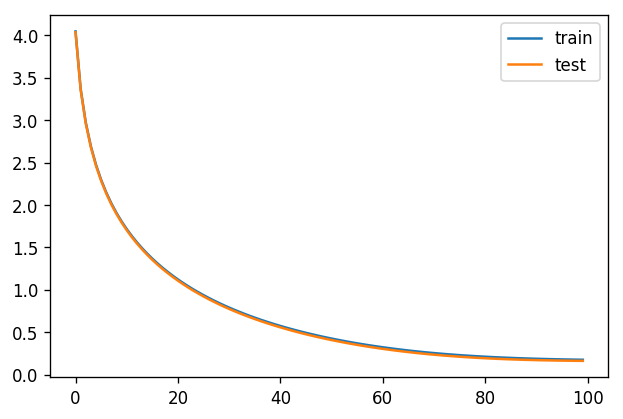

Test loss: 0.163199
Epoch 96, train loss: 0.180526
Epoch 97, train loss: 0.179476
Epoch 98, train loss: 0.178489
Epoch 99, train loss: 0.177594


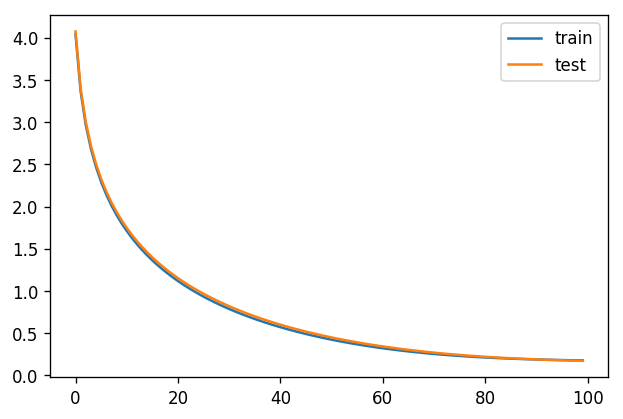

Test loss: 0.172267
Epoch 96, train loss: 0.179317
Epoch 97, train loss: 0.178244
Epoch 98, train loss: 0.177255
Epoch 99, train loss: 0.176345


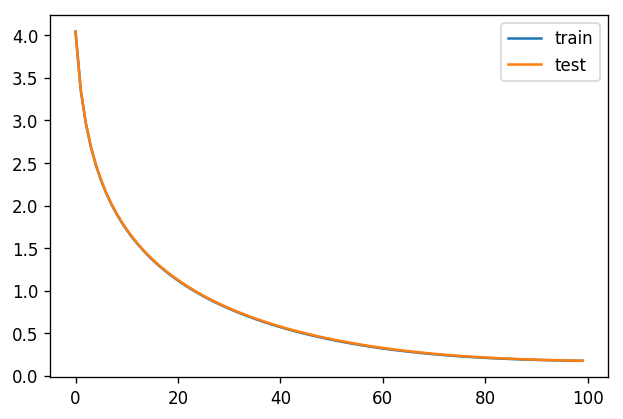

Test loss: 0.177243
Epoch 96, train loss: 0.176066
Epoch 97, train loss: 0.174949
Epoch 98, train loss: 0.173909
Epoch 99, train loss: 0.172926


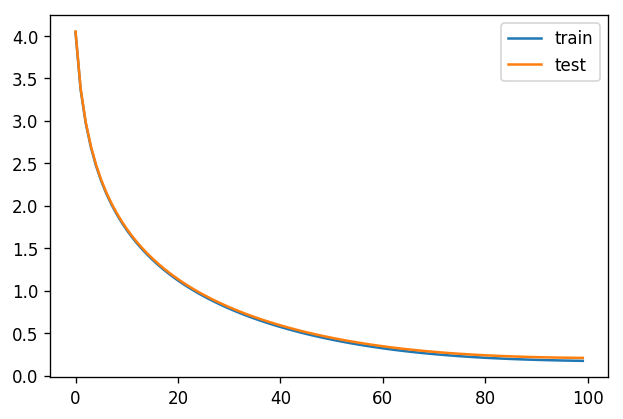

Test loss: 0.207657
Epoch 96, train loss: 0.176237
Epoch 97, train loss: 0.175105
Epoch 98, train loss: 0.174078
Epoch 99, train loss: 0.173088


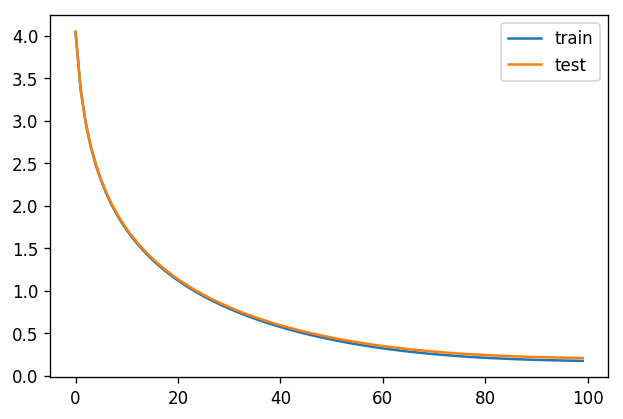

Test loss: 0.206937
Epoch 96, train loss: 0.180614
Epoch 97, train loss: 0.179551
Epoch 98, train loss: 0.178560
Epoch 99, train loss: 0.177641


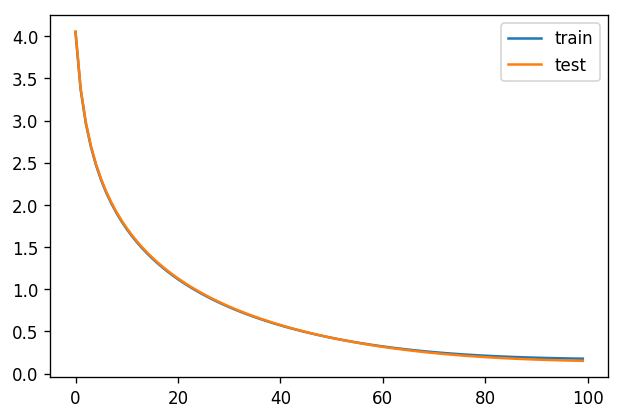

Test loss: 0.151741
Epoch 96, train loss: 0.180063
Epoch 97, train loss: 0.178979
Epoch 98, train loss: 0.178009
Epoch 99, train loss: 0.177080


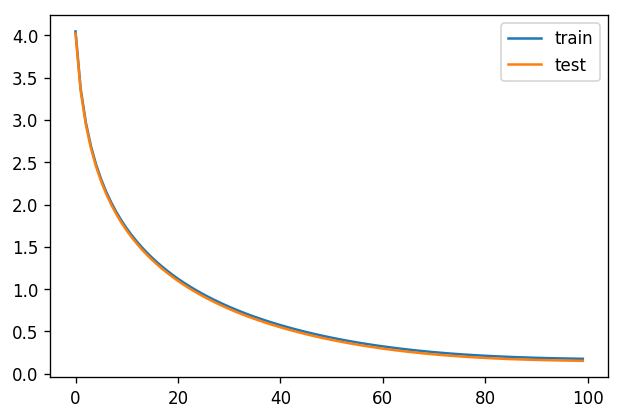

Test loss: 0.152690
Epoch 96, train loss: 0.178722
Epoch 97, train loss: 0.177616
Epoch 98, train loss: 0.176635
Epoch 99, train loss: 0.175687


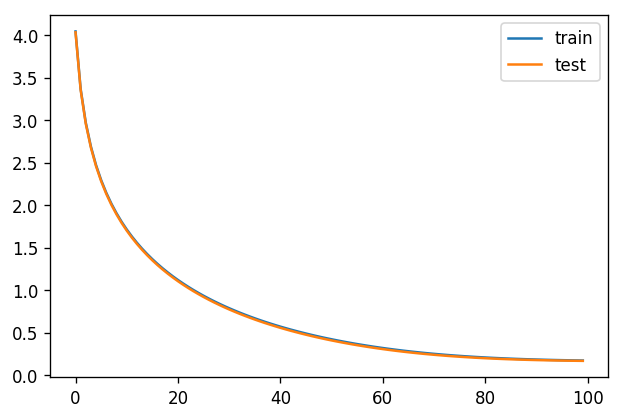

Test loss: 0.171835
Epoch 96, train loss: 0.174552
Epoch 97, train loss: 0.173424
Epoch 98, train loss: 0.172376
Epoch 99, train loss: 0.171455


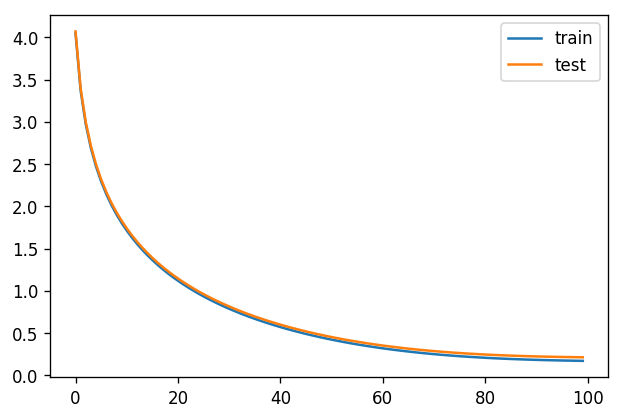

Test loss: 0.213559
Epoch 96, train loss: 0.179488
Epoch 97, train loss: 0.178378
Epoch 98, train loss: 0.177379
Epoch 99, train loss: 0.176421


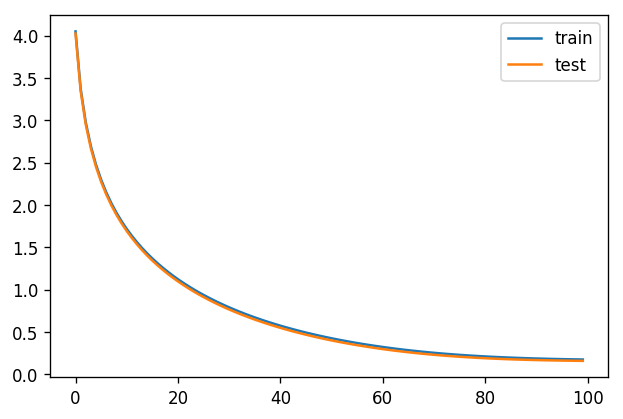

Test loss: 0.160491
10-fold validation: Avg train loss: 0.175435, Avg test loss: 0.177762


In [27]:

train_loss, test_loss = k_fold_cross_valid(k, epochs, verbose_epoch, X_train,
                                           y_train, learning_rate, weight_decay)
print("%d-fold validation: Avg train loss: %f, Avg test loss: %f" %
      (k, train_loss, test_loss))

In [28]:

def learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate,
          weight_decay):
    net = get_net()
    train(net, X_train, y_train, None, None, epochs, verbose_epoch,
          learning_rate, weight_decay)
    preds = net(X_test).asnumpy()
    test['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test['Id'], test['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

Epoch 96, train loss: 0.171248
Epoch 97, train loss: 0.170689
Epoch 98, train loss: 0.170136
Epoch 99, train loss: 0.169676


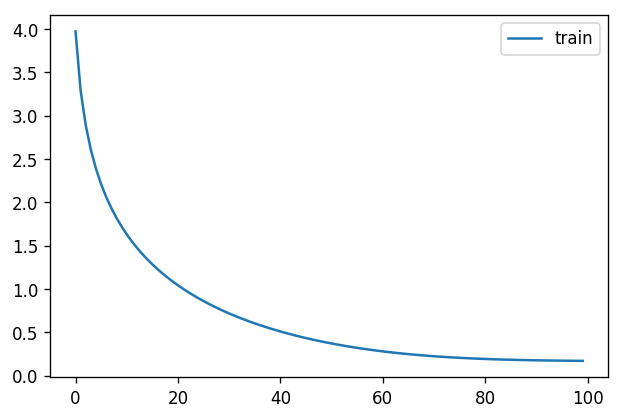

In [29]:
learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate,
      weight_decay)